In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
import numpy as np
import math
from scipy.ndimage.filters import gaussian_filter

Jansen-Rit Neural Mass Model in PyRates
=====================

**1. Model Description**
    - Circuit structure
    - pulse-to-wave transform
    - wave-to-pulse transform

**2. PyRates Implementation**
    - Axon
    - Synapses
    - Population
    - Circuit

**3. Model Validation**
    - Replicating Jansen & Rit (1995), single circuit dynamics experiment

1. Model Description
--------------------

**Circuit Structure**

<img src="img/JR_circuit_original.png",width=400,height=400>

    - 3 populations (pyramidal cells, excitatory interneurons, inhibitory interneurons)
    - population dynamics described by average membrane potential and average firing rate
    - Pulse-to-wave / wave-to-pulse transforms transfer average firing rates into average
      membrane potentials and vice versa
    - Populations communicate with each other via average firing rate projections

**Pulse-To-Wave Transform**

The pulse-to-wave transform is responsible for transforming average firing rates arriving at
the synapses of a population (i.e. neural mass) into an average membrane potential of that population.
The average membrane potential resulting from a single synapse is given the convolution of the incoming firing rates with an impulse response function:
<br/>

$$v(t) = \int_{t' = -\infty}^{t} h_{e/i}(t - t') \otimes p(t') dt'$$

$v = $  average post-synaptic membrane potential <br/>
$h_{e/i} = $ excitatory or inhibitory synaptic kernel (see below) <br/>
$p = $ incoming pre-synaptic average firing-rate <br/>

*Impulse Response Function:*

$$h_{e/i}(t) = \frac{H_{e/i} t \exp(\frac{-t}{\tau_{e/i}})}{\tau_{e/i}}$$

$H_{e/i} = $ efficacy of excitatory/inhibitory synapse (negative for inhibitory ones) <br/>
$\tau_{e/i} = $ lumped time constant of excitatory/inhibitory synapse

**Wave-To-Pulse Transform**

The wave-to-pulse transform is responsible for transforming the average membrane potential of a 
population into an average firing rate this population is generating at its axon hillok. 
This average firing rate is then projected to the synapses of other populations 
and is given by a sigmoidal transform:

$$p(t) = \frac{2e_0}{1 + \exp(r(v_0 - v(t)))}$$

$e_0 = $ half of the maximum firing rate <br/>
$r = $ steepness of the sigmoid <br/>
$v_0 = $ membrane potential threshold. If $v = v_0$, $p(t) = 0.5$ 


2. PyRates Implementation
-------------------------

**Axon**

Implements the Wave-To-Pulse transform described above.
    

Default maximum firing rate (2*e0):  5.0  Hz.
Default membrane potential threshold (v0):  0.006  V.
Default sigmoid steepness (r):  560.0  Hz.


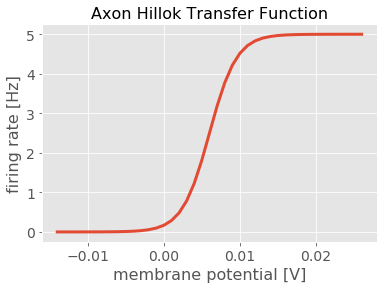

In [2]:
from core.axon import JansenRitAxon

# initialize axon
axon = JansenRitAxon()

# print default parameters (can be changed during initialization)
print('Default maximum firing rate (2*e0): ', axon.transfer_function_args['max_firing_rate'], ' Hz.')
print('Default membrane potential threshold (v0): ', axon.transfer_function_args['membrane_potential_threshold'], ' V.')
print('Default sigmoid steepness (r): ', axon.transfer_function_args['sigmoid_steepness'], ' Hz.')

# plot axon
fig, axes = plt.subplots()
axes = axon.plot_transfer_function(create_plot=False, axes=axes)

**Synapses**

Implement the pulse-to-wave transform described above.

Default synaptic efficacies (He/Hi):  [0.0032500000000000003, -0.022]  V.
Default synaptic time constants (tau_e/tau_i):  [0.01, 0.02]  s.


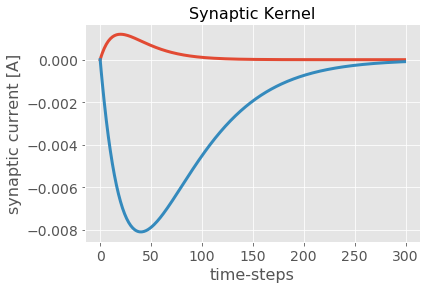

In [3]:
from core.synapse import JansenRitExcitatorySynapse, JansenRitInhibitorySynapse

# instantiate an excitatory and an inhibitory synapse
synapse_e = JansenRitExcitatorySynapse(bin_size=5e-4, max_delay=0.15)
synapse_i = JansenRitInhibitorySynapse(bin_size=5e-4, max_delay=0.15)

# print default parameters (can be changed during initialization)
print('Default synaptic efficacies (He/Hi): ', [synapse_e.efficacy, synapse_i.efficacy], ' V.')
print('Default synaptic time constants (tau_e/tau_i): ', [synapse_e.kernel_function_args['tau'], synapse_i.kernel_function_args['tau']], ' s.')

# plot synaptic kernels
fig, axes = plt.subplots()
axes = synapse_e.plot_synaptic_kernel(create_plot=False, axes=axes)
axes = synapse_i.plot_synaptic_kernel(create_plot=False, axes=axes)

**Populations**
    
    - 3 types: Pyramidal cells, excitatory interneurons, inhibitory interneurons
    - Consist of a Jansen-Rit axon and an excitatory Jansen-Rit synapse
    - Pyramidal cells have an additional inhibitory Jansen-Rit synapse

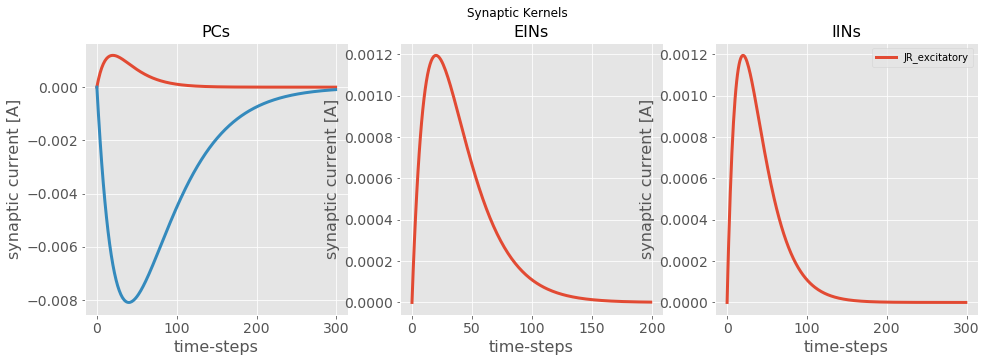

In [4]:
from core.population import JansenRitPyramidalCells, JansenRitInterneurons

# instantiate all 3 populations
pcs = JansenRitPyramidalCells(step_size=5e-4, max_synaptic_delay=0.15)
eins = JansenRitInterneurons(step_size=5e-4, max_synaptic_delay=0.1)
iins = JansenRitInterneurons(step_size=5e-4, max_synaptic_delay=0.15)

# plot synaptic kernels of each population
fig, axes = plt.subplots(1,3, figsize=(16,5))
plt.suptitle('Synaptic Kernels')
ax1 = axes[0]
ax1 = pcs.plot_synaptic_kernels(create_plot=False, axes=ax1)
ax1.set_title('PCs')
ax2 = axes[1]
ax2 = eins.plot_synaptic_kernels(create_plot=False, axes=ax2)
ax2.set_title('EINs')
ax3 = axes[2]
ax3 = iins.plot_synaptic_kernels(create_plot=False, axes=ax3)
ax3.set_title('IINs')

**Circuit**

 Models cortical column as interaction between PCs, EINs and IINs.

1.0 seconds simulation of JRC took 0.23890376091003418seconds.


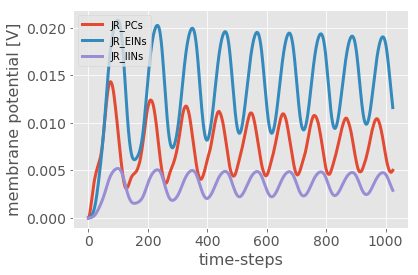

In [11]:
from core.circuit import JansenRitCircuit
from time import time

# instantiate circuit
step_size = 1/1024
jrc = JansenRitCircuit(step_size=step_size, max_synaptic_delay=0.2)

# define input to circuit
simulation_time = 1.
simulation_steps = int(simulation_time / step_size)
synaptic_input = np.zeros((simulation_steps, 3, 2))                       # 1000 time-steps (1 s) x 3 populations x 2 synapses
synaptic_input[:, 0, 0] = 22. * np.random.randn(simulation_steps) + 220.  # gaussian input to PCs

# simulate circuit behavior
t_start = time()
jrc.run(simulation_time=simulation_time, synaptic_inputs=synaptic_input)
t_end = time()

print(str(simulation_time) + ' seconds simulation of JRC took ' + str(t_end - t_start) + 'seconds.')

# plot resulting membrane potential traces
fig, axes = plt.subplots()
axes = jrc.plot_population_states(create_plot=False, axes=axes)

# store results + information
#from core.utility import get_simulation_data, save_simulation_data_to_file
#jrc.to_json(path='../tests/resources', filename='test_4_1_JR_flat')
#run_info, states = get_simulation_data(jrc)
#save_simulation_data_to_file(states, run_info, dirname='test_4_1_JR_flat_data', path='../tests/resources/')

3. Model Validation
-------------------

**Replicating Jansen & Rit (1995) Section 3.1**

*Connectivity scaling experiment:*

    - Circuit with parametrization as reported above, consisting of PCs, EINs and IINs
    - Simulation of circuit behavior for 2 s. 
    - Uniformly distributed input between 120 and 320 Hz delivered to PCs throughout the simulation
    - 6 conditions for lumped connectivity constant C: 68, 128, 135, 270, 675, 1350
    - Results can be seen in figure below
    
<img src="img/JR_single_circuit_dynamics.jpg",width=400,height=400>

*Replication of the experiment with PyRates:*

In [14]:
from core.population import JansenRitPyramidalCells, JansenRitInterneurons
from core.circuit import Circuit

# circuit parameters
step_size = 5e-4
max_synaptic_delay = 0.5
n_populations = 3
n_synapses = 2

# instantiate cell populations and connectivity parameters
pcs = JansenRitPyramidalCells(step_size=step_size, max_synaptic_delay=max_synaptic_delay)
eins = JansenRitInterneurons(step_size=step_size, max_synaptic_delay=max_synaptic_delay)
iins = JansenRitInterneurons(step_size=step_size, max_synaptic_delay=max_synaptic_delay)

connectivity = np.zeros((n_populations, n_populations, n_synapses))
delays = np.zeros((n_populations, n_populations))

# define experimental conditions
C = [68., 128., 135., 270., 675., 1350.]
simulation_time = 2.5                                                 # 0.5 additional cut-off seconds 
time_steps = int(simulation_time / step_size)
synaptic_input = np.zeros((time_steps, n_populations, n_synapses))                        
synaptic_input[:, 0, 0] = np.random.uniform(120, 320, time_steps)    # input to PCs

# perform experiment for each condition

pc_state_coll = list()                                               # used to collect the membrane potential of the PCs

for c in C:
    
    # build connectivity matrix
    connectivity[:, :, 0] = np.array([[0., 0.8 * c, 0.],
                                      [1.0 * c, 0., 0.],
                                      [0.25 * c, 0., 0.]])
    connectivity[:, :, 1] = np.array([[0., 0., 0.25 * c],
                                      [0., 0., 0.],
                                      [0., 0., 0.]])
    
    # instantiate circuit
    jrc = Circuit(populations=[pcs, eins, iins], connectivity=connectivity, delays=delays, step_size=step_size)
    
    # perform experiment
    jrc.run(synaptic_inputs=synaptic_input, simulation_time=simulation_time)
    
    # collect PC membrane potentials
    pc_state_coll.append(np.squeeze(jrc.get_population_states(0, [0], time_window=[0.5, 2.5])))

    # clear state history of populations
    pcs.clear()
    eins.clear()
    iins.clear()

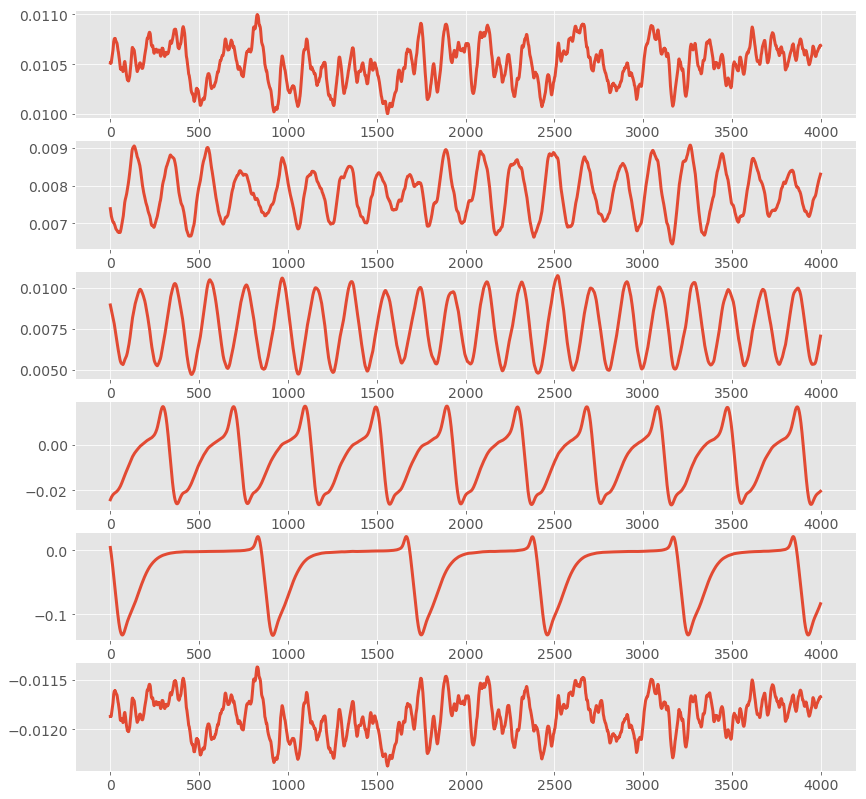

In [15]:
# plot results
fig, axes = plt.subplots(6, 1, figsize=(14, 14))

for i in range(len(pc_state_coll)):
    axes[i].plot(pc_state_coll[i])

*Synaptic efficacy scaling experiment:*

* Same set-up as described in first experiment
* Connectivity scaling fixed at C = 135.
* Synaptic efficacies He and Hi systematically varied

*PyRates replication:*

In [16]:
from core.circuit import JansenRitCircuit

# parameters
############

# connectivity scaling
c = 135.

# axon params
axon_params = {'membrane_potential_threshold': 6e-3}
axon_params = [axon_params for i in range(3)]

# synaptic parameters
synapse_params = [{'efficacy': 3.25e-3}, {'efficacy': -22e-3}]

# define experimental conditions
simulation_time = 2.5                                                 # 0.5 additional cut-off seconds 
time_steps = int(simulation_time / step_size)
synaptic_input = np.zeros((time_steps, n_populations, n_synapses))                        
synaptic_input[:, 0, 0] = np.random.uniform(120, 320, time_steps)    # input to PCs
exc_syn_eff = np.array([2.5, 3.25, 5.5, 7.5, 3.25]) * 1e-3
inh_syn_eff = np.array([19.5, 19.5, 19.5, 110., 110.]) * 1e-3

# perform experiment for each condition
pc_state_coll = list()                                               # used to collect the membrane potential of the PCs
conditions = list()

for H_e, H_i in zip(exc_syn_eff, inh_syn_eff):
        
    # set synaptic efficacies
    synapse_params[0]['efficacy'] = H_e
    synapse_params[1]['efficacy'] = -H_i

    jrc = JansenRitCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, connectivity_scaling=c,
                           synapse_params=synapse_params, axon_params=axon_params)

    # perform experiment
    jrc.run(synaptic_inputs=synaptic_input, simulation_time=simulation_time)

    # collect PC membrane potentials and condition
    pc_state_coll.append(np.squeeze(jrc.get_population_states(0, [0], time_window=[0.5, simulation_time])))
    conditions.append([H_e, H_i])

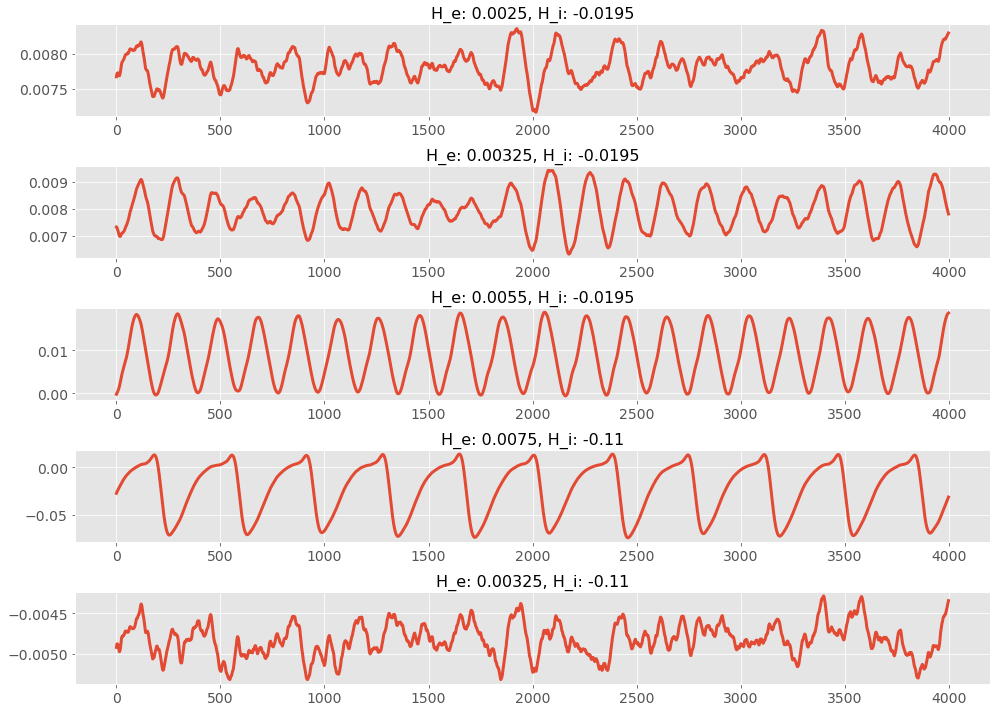

In [17]:
# plot results
fig, axes = plt.subplots(len(pc_state_coll), 1, figsize=(14, 10))

for i in range(len(pc_state_coll)):
    axes[i].plot(pc_state_coll[i])
    axes[i].set_title('H_e: ' + str(conditions[i][0]) + ', H_i: ' + str(-conditions[i][1]))

plt.tight_layout()

**Replicating Jansen & Rit (1995) Section 3.2**

*Zero-delay two column experiment:*

* 2 NMMs with standard parametrization leading to alpha-like activity
* Coupled without delays
* coupling constants k1 and k2 varied between 0 and 120

*PyRates replication:*

In [18]:
from core.circuit import CircuitFromCircuit

# experimental conditions
k1_col = np.array([10., 20., 60., 120.])
k2_col = np.array([10., 20., 60., 120.])
connectivity = np.zeros((2, 2, 2))
delays = np.zeros((2, 2))
synaptic_input = np.zeros((time_steps, 6, 2))
synaptic_input[:, 0, 0] = np.random.uniform(120, 320, time_steps)
synaptic_input[:, 3, 0] = np.random.uniform(120, 320, time_steps)

# circuits
jrc1 = JansenRitCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay)
jrc2 = JansenRitCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay)

# perform experiments:
pc_state_col = list()
conditions = list()

for k1, k2 in zip(k1_col, k2_col):
        
    # build connectivity matrix
    connectivity[0, 1, 0] = k1
    connectivity[1, 0, 0] = k2

    # connect circuits
    jrc_comb = CircuitFromCircuit([jrc1, jrc2], connectivity, delays)

    # run combined circuit
    jrc_comb.run(synaptic_input, simulation_time)

    # collect run information
    pc_state_col.append(np.squeeze(jrc_comb.get_population_states(0, [0, 3], time_window=[0.5, simulation_time])))
    conditions.append([k1, k2])

    jrc1.clear()
    jrc2.clear()

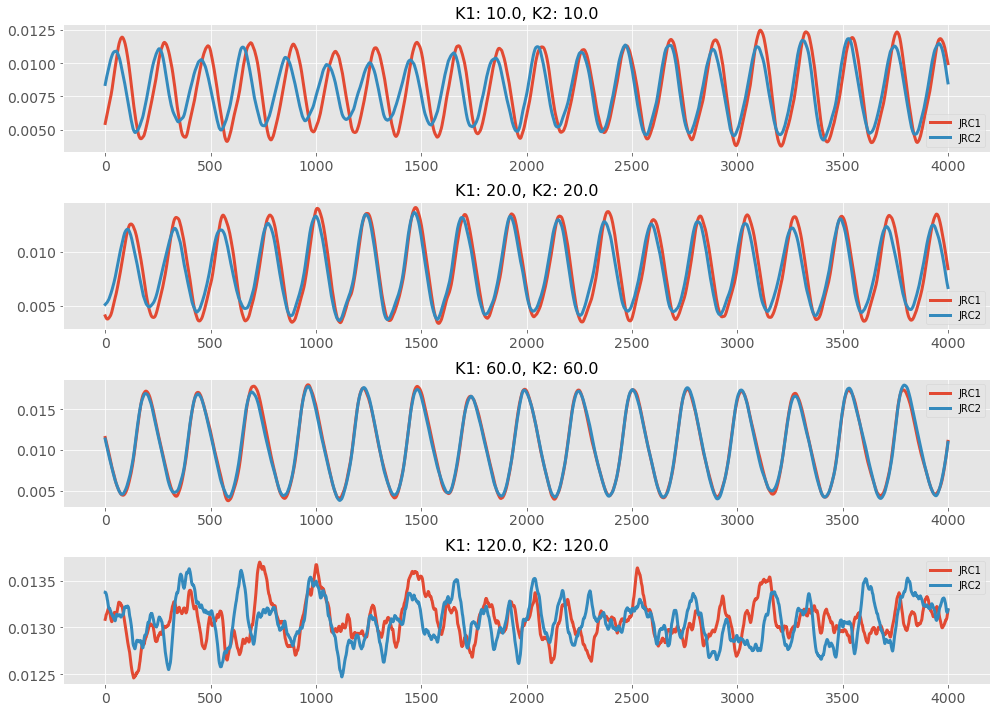

In [19]:
# plot results
fig, axes = plt.subplots(len(pc_state_col), 1, figsize=(14, 10))

for i in range(len(pc_state_col)):
    axes[i].plot(pc_state_col[i])
    axes[i].set_title('K1: ' + str(conditions[i][0]) + ', K2: ' + str(conditions[i][1]))
    axes[i].legend(['JRC1', 'JRC2'])

plt.tight_layout()

**Replicating some example configurations of Spiegler et al. (2010)**

    - Shows dependence of Jansen-Rit NMM on initial condition
    - Shows different types of dynamic states / fixed points etc. of the standard Jansen-Rit NMM
    - Same circuit set-up as described above
    - input is defined as direct offset to the membrane potential of the populations

*Fig. 2 of Spiegler et al. (2010):*

    - standard Jansen-Rit parametrization
    - shows different dynamical states of circuit as function of pyramidal cell input
    - For a certain input range (~4 mV) the circuit has different fixed points depending on its past
    - large amplitude spiking behavior expected when pyramidal cell membrane potential started at around 2 mV
    - Low amplitude oscillating behavior expected when pyramidal cell membrane potential started at around 6 mV

*Replicating with PyRates:*

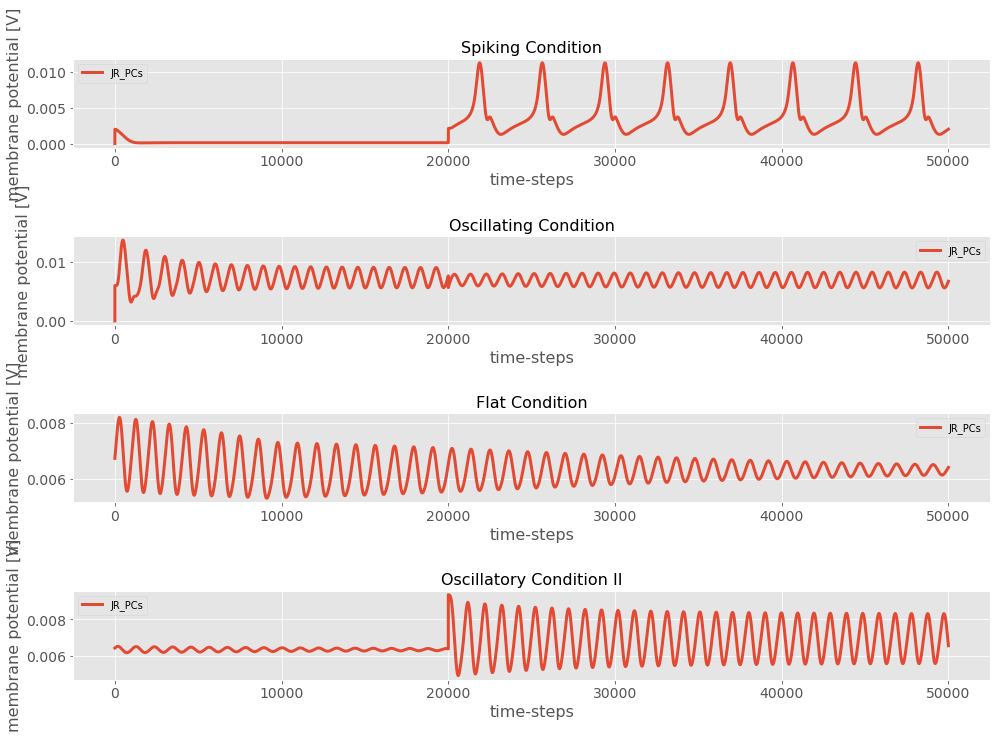

In [20]:
from core.circuit import JansenRitCircuit

# define parameters and conditions
##################################

# circuit parameters
step_size = 1e-4
max_synaptic_delay = 1.0
init_states = np.zeros(3)

# simulation parameters
simulation_time = 5.
init_time = 2.
simulation_steps = int(simulation_time / step_size)
init_steps = int(init_time / step_size)

# input
synaptic_input = np.zeros((simulation_steps, 3, 2))
extrinsic_current = np.zeros((simulation_steps, 3))
extrinsic_current[init_steps:, 0] = 4e-3

# instantiate circuit, run experiments and plot results
#######################################################

# plot preparation
fig, axes = plt.subplots(4, 1, figsize=(14,10))

# experiment 1
extrinsic_current[:init_steps, 0] = 2e-3
jrc = JansenRitCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, init_states=init_states)
jrc.run(synaptic_input, simulation_time, extrinsic_current=extrinsic_current)
axes[0] = jrc.plot_population_states([0], time_window=[0., simulation_time], create_plot=False, axes=axes[0])
axes[0].set_title('Spiking Condition')

jrc.clear()

# experiment 2
extrinsic_current[:init_steps, 0] = 6e-3
jrc = JansenRitCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, init_states=init_states)
jrc.run(synaptic_input, simulation_time, extrinsic_current=extrinsic_current)
axes[1] = jrc.plot_population_states([0], time_window=[0., simulation_time], create_plot=False, axes=axes[1])
axes[1].set_title('Oscillating Condition')

# experiment 3
extrinsic_current[:int(init_steps/2), 0] = np.linspace(4e-3,1e-3,int(init_steps/2))
extrinsic_current[int(init_steps/2):, 0] = 1e-3
#extrinsic_current[init_steps:, 0] = 4e-3
jrc.run(synaptic_input, simulation_time, extrinsic_current=extrinsic_current)
axes[2] = jrc.plot_population_states([0], time_window=[simulation_time, 2*simulation_time], create_plot=False, axes=axes[2])
axes[2].set_title('Flat Condition')

# experiment 4
extrinsic_current[:init_steps, 0] = 1e-3
extrinsic_current[init_steps:, 0] = 4e-3
jrc.run(synaptic_input, simulation_time, extrinsic_current=extrinsic_current)
axes[3] = jrc.plot_population_states([0], time_window=[2*simulation_time, 3*simulation_time], create_plot=False, axes=axes[3])
axes[3].set_title('Oscillatory Condition II')

plt.tight_layout()

*Fig. 13 of Spiegler et al. (2010):*

    - standard Jansen-Rit parametrization
    - extrinsic input to inhibitory interneurons is increased
    - gaussian input (mean = 6.5 mV, std = 1.3 mV) delivered to pyramidal cells
    - 2 bifurcations shown while ramping up the inhibitory interneuron input

*Replicating Fig. 13 of Spiegler et al. (2010):*

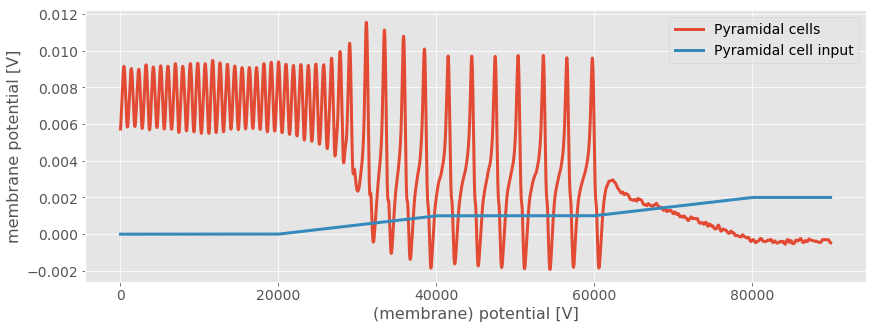

In [21]:
from core.circuit import JansenRitCircuit

# define parameters and conditions
##################################

# circuit parameters
step_size = 1e-4
max_synaptic_delay = 1.0
init_states = np.zeros(3)

# simulation parameters
simulation_time = 10.
change_time = 2.
cutoff_time = 1.
simulation_steps = int(simulation_time / step_size)
change_steps = int(change_time / step_size)
cutoff_steps = int(cutoff_time / step_size)

# input conditions
iin_input = np.array([0., 1., 1., 2., 2.]) * 1e-3
synaptic_input = np.zeros((simulation_steps, 3, 2))
extrinsic_current = np.zeros((simulation_steps, 3))
extrinsic_current[:, 0] = np.random.normal(6.5e-3, 1.3e-3, simulation_steps)
extrinsic_current[:, 0] = gaussian_filter(extrinsic_current[:, 0], sigma=100.)

for i in range(len(iin_input)):
    if not (i % 2 == 1):
        extrinsic_current[cutoff_steps+i*change_steps:cutoff_steps+(i+1)*change_steps, 2] = iin_input[i]
    else:
        extrinsic_current[cutoff_steps+i*change_steps:cutoff_steps+(i+1)*change_steps, 2] = np.linspace(iin_input[i-1], iin_input[i], change_steps)

# instantiate circuit, run experiment and plot results
######################################################

# plot preparation
fig, axes = plt.subplots(figsize=(14,5))

# instantiation
jrc = JansenRitCircuit(step_size=step_size, max_synaptic_delay=max_synaptic_delay, init_states=init_states)

# experiment
jrc.run(synaptic_input, simulation_time, extrinsic_current=extrinsic_current)
axes = jrc.plot_population_states([0], time_window=[cutoff_time, simulation_time], create_plot=False, axes=axes)
axes.plot(extrinsic_current[cutoff_steps:, 2])
axes.legend(['Pyramidal cells', 'Pyramidal cell input'], fontsize=14)
axes.set_xlabel('(membrane) potential [V]')